In [1]:
# %load_ext cudf.pandas
# %load_ext cuml.accel
!pip install --upgrade -qq shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.2 MB/s eta 0:00:00


In [2]:
import torch
import sys
import os
import gc

import joblib
import pickle

## -- DATA MANIPUALATION --
import numpy as np
import pandas as pd
import random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shap

## -- FUNCTIONAL TOOLS --
from google.colab import files
from itertools import combinations
from tqdm.notebook import tqdm
from time import time

# ## SCIKIT-LEARN
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector as SFS1
from mlxtend.feature_selection import SequentialFeatureSelector as SFS2

# -- GBDTs --
import xgboost as xgb
import lightgbm as lgb
try:
    import catboost as cgb
except:
    %pip install -qq -U catboost
    import catboost as cgb

import warnings

In [3]:
##### --- GLOBAL SETTINGS --- #####
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', None)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Set Global Seed --
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## -- Set Device-Agnostic code --
USE_cud = "cuda" if torch.cuda.is_available() else "cpu"
USE_gpu = "gpu" if torch.cuda.is_available() else "cpu"
USE_GPU = "GPU" if torch.cuda.is_available() else "CPU"

COLOR = '\033[32m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [4]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e10/"
submit = pd.read_csv(PATH+"sample_submission.csv")
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
orig = pd.read_csv("/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_100k.csv")

TARGET = "accident_risk"
NUM_FEATURES = test.select_dtypes(include='number').columns.tolist()
CAT_FEATURES = test.select_dtypes(exclude='number').columns.tolist()
ALL_FEATURES = NUM_FEATURES + CAT_FEATURES

In [5]:
# print(f"Train ID column is Unique: {train.id.is_unique}")
# print(f"Test ID column is Unique: {test.id.is_unique}")

In [6]:
## -- Merge original as ROWS --
train = pd.concat([train, orig], ignore_index=True)
train.shape

# ## -- Merge original as COLUMNS --
# ORIG_FEATURES = []
# print(f"Merging {len(ALL_FEATURES)} features... ", end="")
# for c in ALL_FEATURES:
#     tmp = orig.groupby(c)[TARGET].mean()
#     n = f"orig_{c}"
#     print(f"{n}, ", end="")
#     tmp.name = n
#     train = train.merge(tmp, on=c, how='left')
#     test = test.merge(tmp, on=c, how='left')
#     ORIG_FEATURES.append(n)

(617754, 13)

In [7]:
display(train.head())
train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617754 entries, 0 to 617753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               617754 non-null  object 
 1   num_lanes               617754 non-null  int64  
 2   curvature               617754 non-null  float64
 3   speed_limit             617754 non-null  int64  
 4   lighting                617754 non-null  object 
 5   weather                 617754 non-null  object 
 6   road_signs_present      617754 non-null  bool   
 7   public_road             617754 non-null  bool   
 8   time_of_day             617754 non-null  object 
 9   holiday                 617754 non-null  bool   
 10  school_season           617754 non-null  bool   
 11  num_reported_accidents  617754 non-null  int64  
 12  accident_risk           617754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 44.8+ MB


In [8]:
display(test.head())
test.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
id,,,,,,,,,,,,
517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


<class 'pandas.core.frame.DataFrame'>
Index: 172585 entries, 517754 to 690338
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               172585 non-null  object 
 1   num_lanes               172585 non-null  int64  
 2   curvature               172585 non-null  float64
 3   speed_limit             172585 non-null  int64  
 4   lighting                172585 non-null  object 
 5   weather                 172585 non-null  object 
 6   road_signs_present      172585 non-null  bool   
 7   public_road             172585 non-null  bool   
 8   time_of_day             172585 non-null  object 
 9   holiday                 172585 non-null  bool   
 10  school_season           172585 non-null  bool   
 11  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(3), object(4)
memory usage: 12.5+ MB


In [9]:
display(orig.head())
orig.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,rural,2,0.29,70,night,rainy,False,True,evening,False,False,1,0.64
1,highway,1,0.34,25,dim,clear,False,False,morning,False,False,3,0.27
2,rural,2,0.76,70,night,foggy,True,False,evening,True,True,1,0.76
3,rural,3,0.37,70,night,foggy,True,False,morning,False,True,0,0.60
4,highway,3,0.39,45,dim,rainy,False,True,morning,False,False,0,0.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               100000 non-null  object 
 1   num_lanes               100000 non-null  int64  
 2   curvature               100000 non-null  float64
 3   speed_limit             100000 non-null  int64  
 4   lighting                100000 non-null  object 
 5   weather                 100000 non-null  object 
 6   road_signs_present      100000 non-null  bool   
 7   public_road             100000 non-null  bool   
 8   time_of_day             100000 non-null  object 
 9   holiday                 100000 non-null  bool   
 10  school_season           100000 non-null  bool   
 11  num_reported_accidents  100000 non-null  int64  
 12  accident_risk           100000 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 7.2+ MB


In [10]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
road_type,617754,3,highway,207096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_lanes,617754.0,NaN,NaN,NaN,2.492125,1.120034,1.0,1.0,2.0,3.0,4.0
curvature,617754.0,NaN,NaN,NaN,0.490645,0.275273,0.0,0.26,0.51,0.72,1.0
speed_limit,617754.0,NaN,NaN,NaN,46.265059,15.879793,25.0,35.0,45.0,60.0,70.0
lighting,617754,3,dim,217388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,617754,3,foggy,214737,NaN,NaN,NaN,NaN,NaN,NaN,NaN
road_signs_present,617754,2,False,309277,NaN,NaN,NaN,NaN,NaN,NaN,NaN
public_road,617754,2,True,309922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_of_day,617754,3,morning,206784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,617754,2,True,311053,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
orig.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
road_type,100000,3,urban,33449,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_lanes,100000.0,NaN,NaN,NaN,2.4953,1.117958,1.0,1.0,2.0,3.0,4.0
curvature,100000.0,NaN,NaN,NaN,0.500619,0.288691,0.0,0.25,0.5,0.75,1.0
speed_limit,100000.0,NaN,NaN,NaN,47.05455,16.321527,25.0,35.0,45.0,60.0,70.0
lighting,100000,3,dim,33562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,100000,3,clear,33511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
road_signs_present,100000,2,True,50012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
public_road,100000,2,False,50123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_of_day,100000,3,morning,33374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,100000,2,True,50365,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Check if column names are the same regardless of order
are_same_set = set(train.columns) == set(orig.columns)
print(f"Are column names the same regardless of order (train vs orig)? {are_same_set}")

# Check if column names are exactly the same and in the same order
are_same_exact = train.columns.equals(orig.columns)
print(f"Are column names exactly the same and in the same order (train vs orig)? {are_same_exact}")

Are column names the same regardless of order (train vs orig)? True
Are column names exactly the same and in the same order (train vs orig)? True


In [13]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
# ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in ALL_FEATURES:
    TRAIN_UNIQUE[col] = train[col].nunique()
    # ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         # pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='Spectral')

,num_lanes,curvature,speed_limit,num_reported_accidents,road_type,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season
Train,4,261,5,11,3,3,3,2,2,3,2,2
Test,4,195,5,8,3,3,3,2,2,3,2,2


In [14]:
def distplots_data(
                    train: pd.DataFrame,
                    test: pd.DataFrame,
                    orig: pd.DataFrame,
                    features: list[str]):

    # 1) Concatenate data
    df = pd.concat([
        train[features].assign(Source='Train'),
        test[features].assign(Source='Test'),
        orig[features].assign(Source='Original')
    ], axis=0, ignore_index=True)
    
    PALETTE = ['g', 'r', 'orange']
    
    # 2) Create a grid: one row per feature, two columns (KDE vs Boxplot)
    n_features = len(features)
    fig, axs = plt.subplots(n_features, 2, figsize=(18, max(5, n_features * 5)),
                            gridspec_kw={'hspace': 0.2, 'wspace': 0.15, 'width_ratios': [0.7, 0.3]})
    
    # Ensure axs is always 2D for consistent indexing
    if n_features == 1:
        axs = axs.reshape(1, 2)
    
    for i, col in enumerate(features):
        ax_kde = axs[i, 0]
        sns.kdeplot(data=df[[col, 'Source']], x=col, hue='Source', palette=PALETTE, ax=ax_kde, linewidth=2)
        ax_kde.set(xlabel='', ylabel='')
        ax_kde.set_title(f"\n{col}")
        ax_kde.grid()
    
        ax_box = axs[i, 1]
        sns.boxplot(data=df, y=col, x='Source', width=0.5, linewidth=1, fliersize=1, ax=ax_box, palette=PALETTE)
        ax_box.set_title(f"\n{col}")
        ax_box.set(xlabel='', ylabel='')
        ax_box.tick_params(axis='both', which='major')
        ax_box.set_xticklabels(['Train', 'Test', 'Original'])
    
    plt.tight_layout()
    plt.show()
    
    # 3) Second figure: target distribution (Train vs Original)
    fix, axs2 = plt.subplots(1, 2, figsize=(18, 5),
                              gridspec_kw={'wspace': 0.15, 'width_ratios': [0.7, 0.3]})
    # KDEs for TARGET from train vs orig
    sns.kdeplot(data=train, x=TARGET, color=PALETTE[0], ax=axs2[0], linewidth=2, label='Train')
    sns.kdeplot(data=orig,  x=TARGET, color=PALETTE[1], ax=axs2[0], linewidth=2, label='Original')
    axs2[0].legend()
    axs2[0].grid()
    # Boxplot for TARGET across sources
    sns.boxplot(data=[train[TARGET], orig[TARGET]], width=0.6,
                linewidth=1, fliersize=1, ax=axs2[1], palette=PALETTE)
    axs2[1].set_xticklabels(['Train', 'Original'])
    plt.suptitle("-- Target Distribution --", fontsize=15, fontweight='semibold')
    plt.tight_layout()
    plt.show()

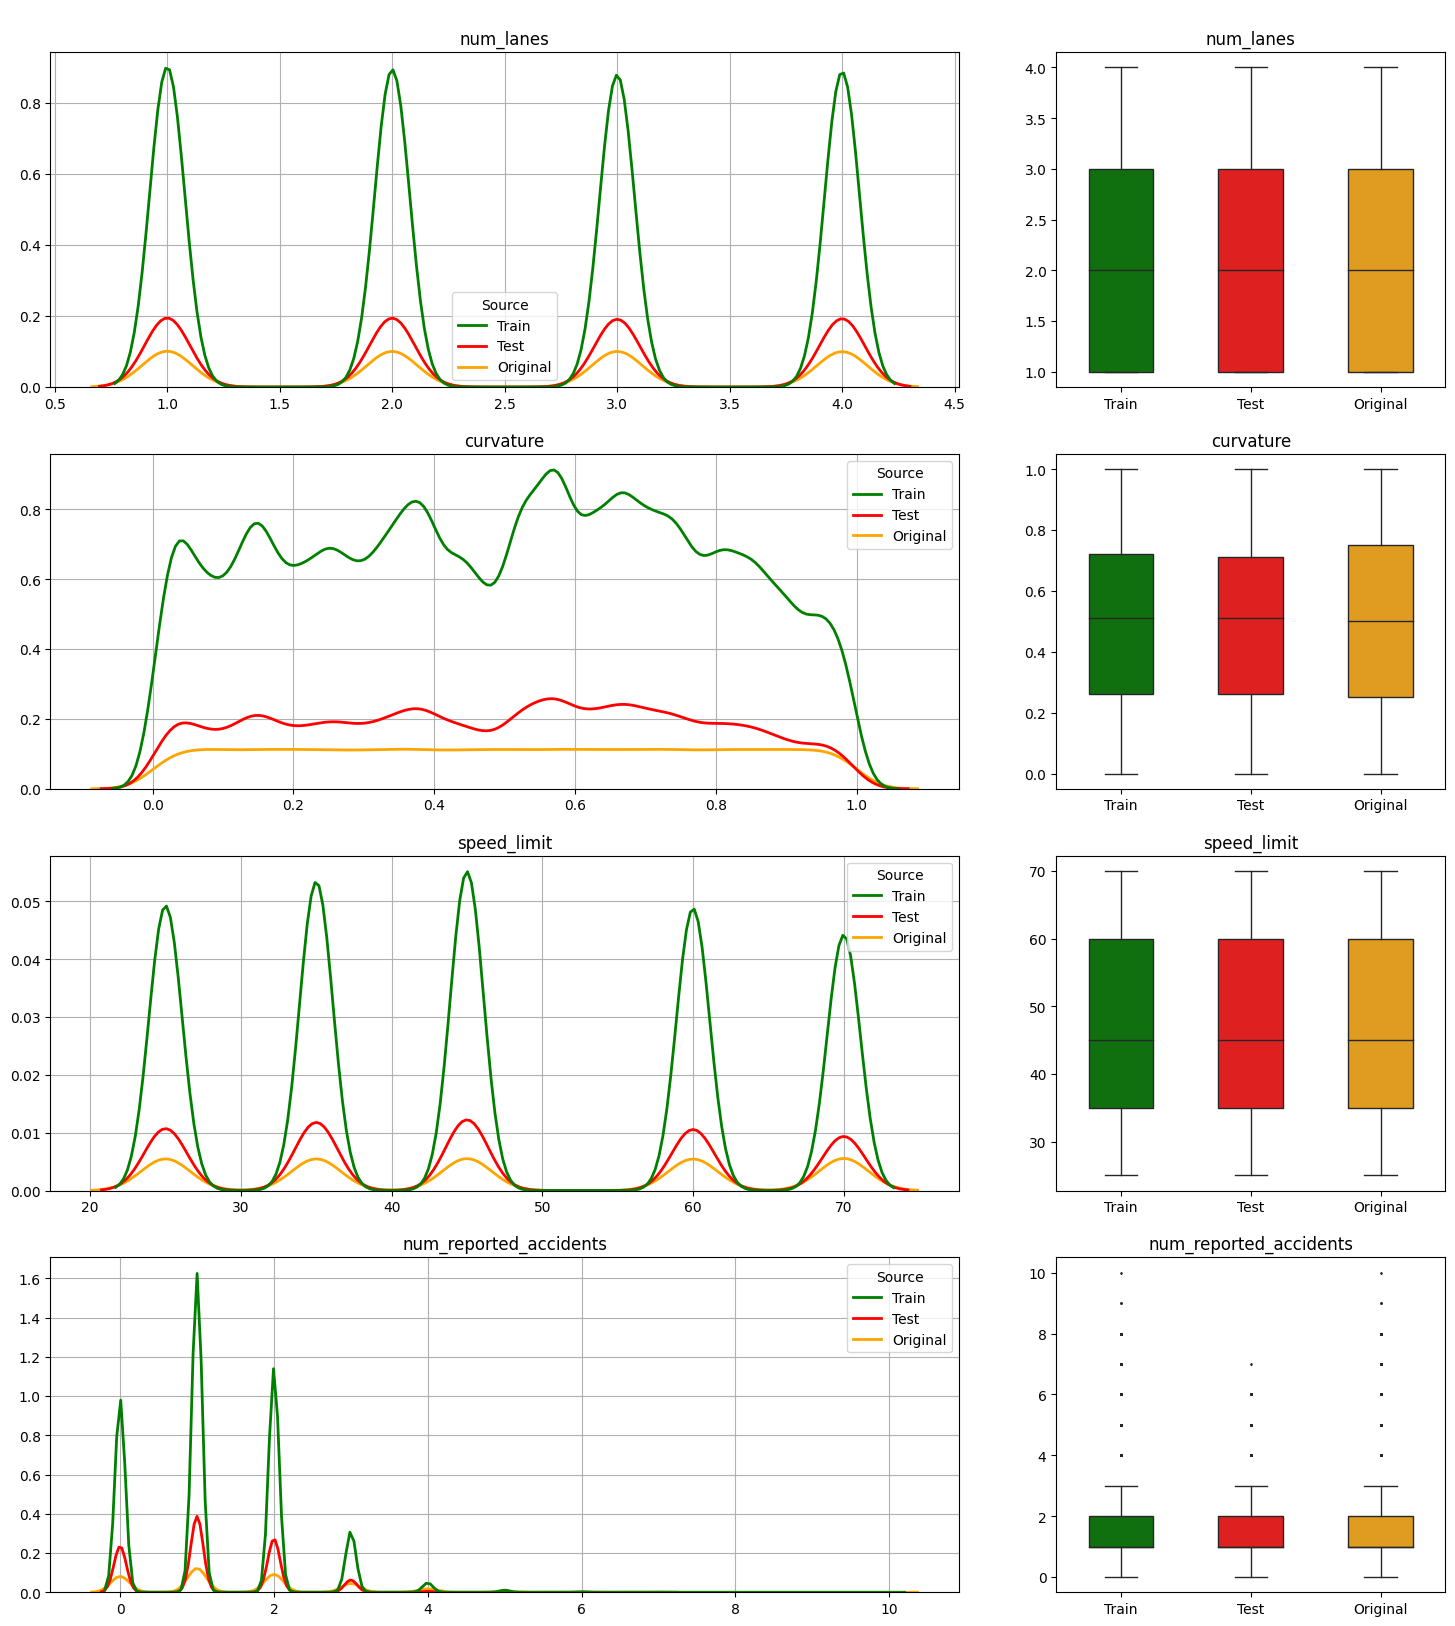

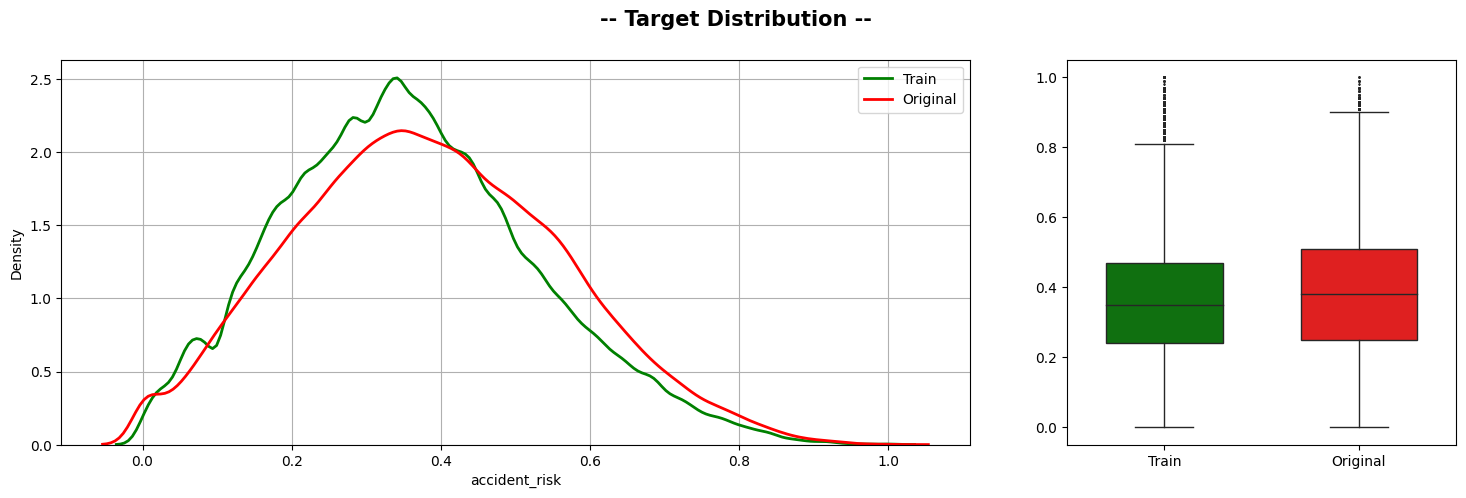

In [15]:
distplots_data(train, test, orig, NUM_FEATURES)

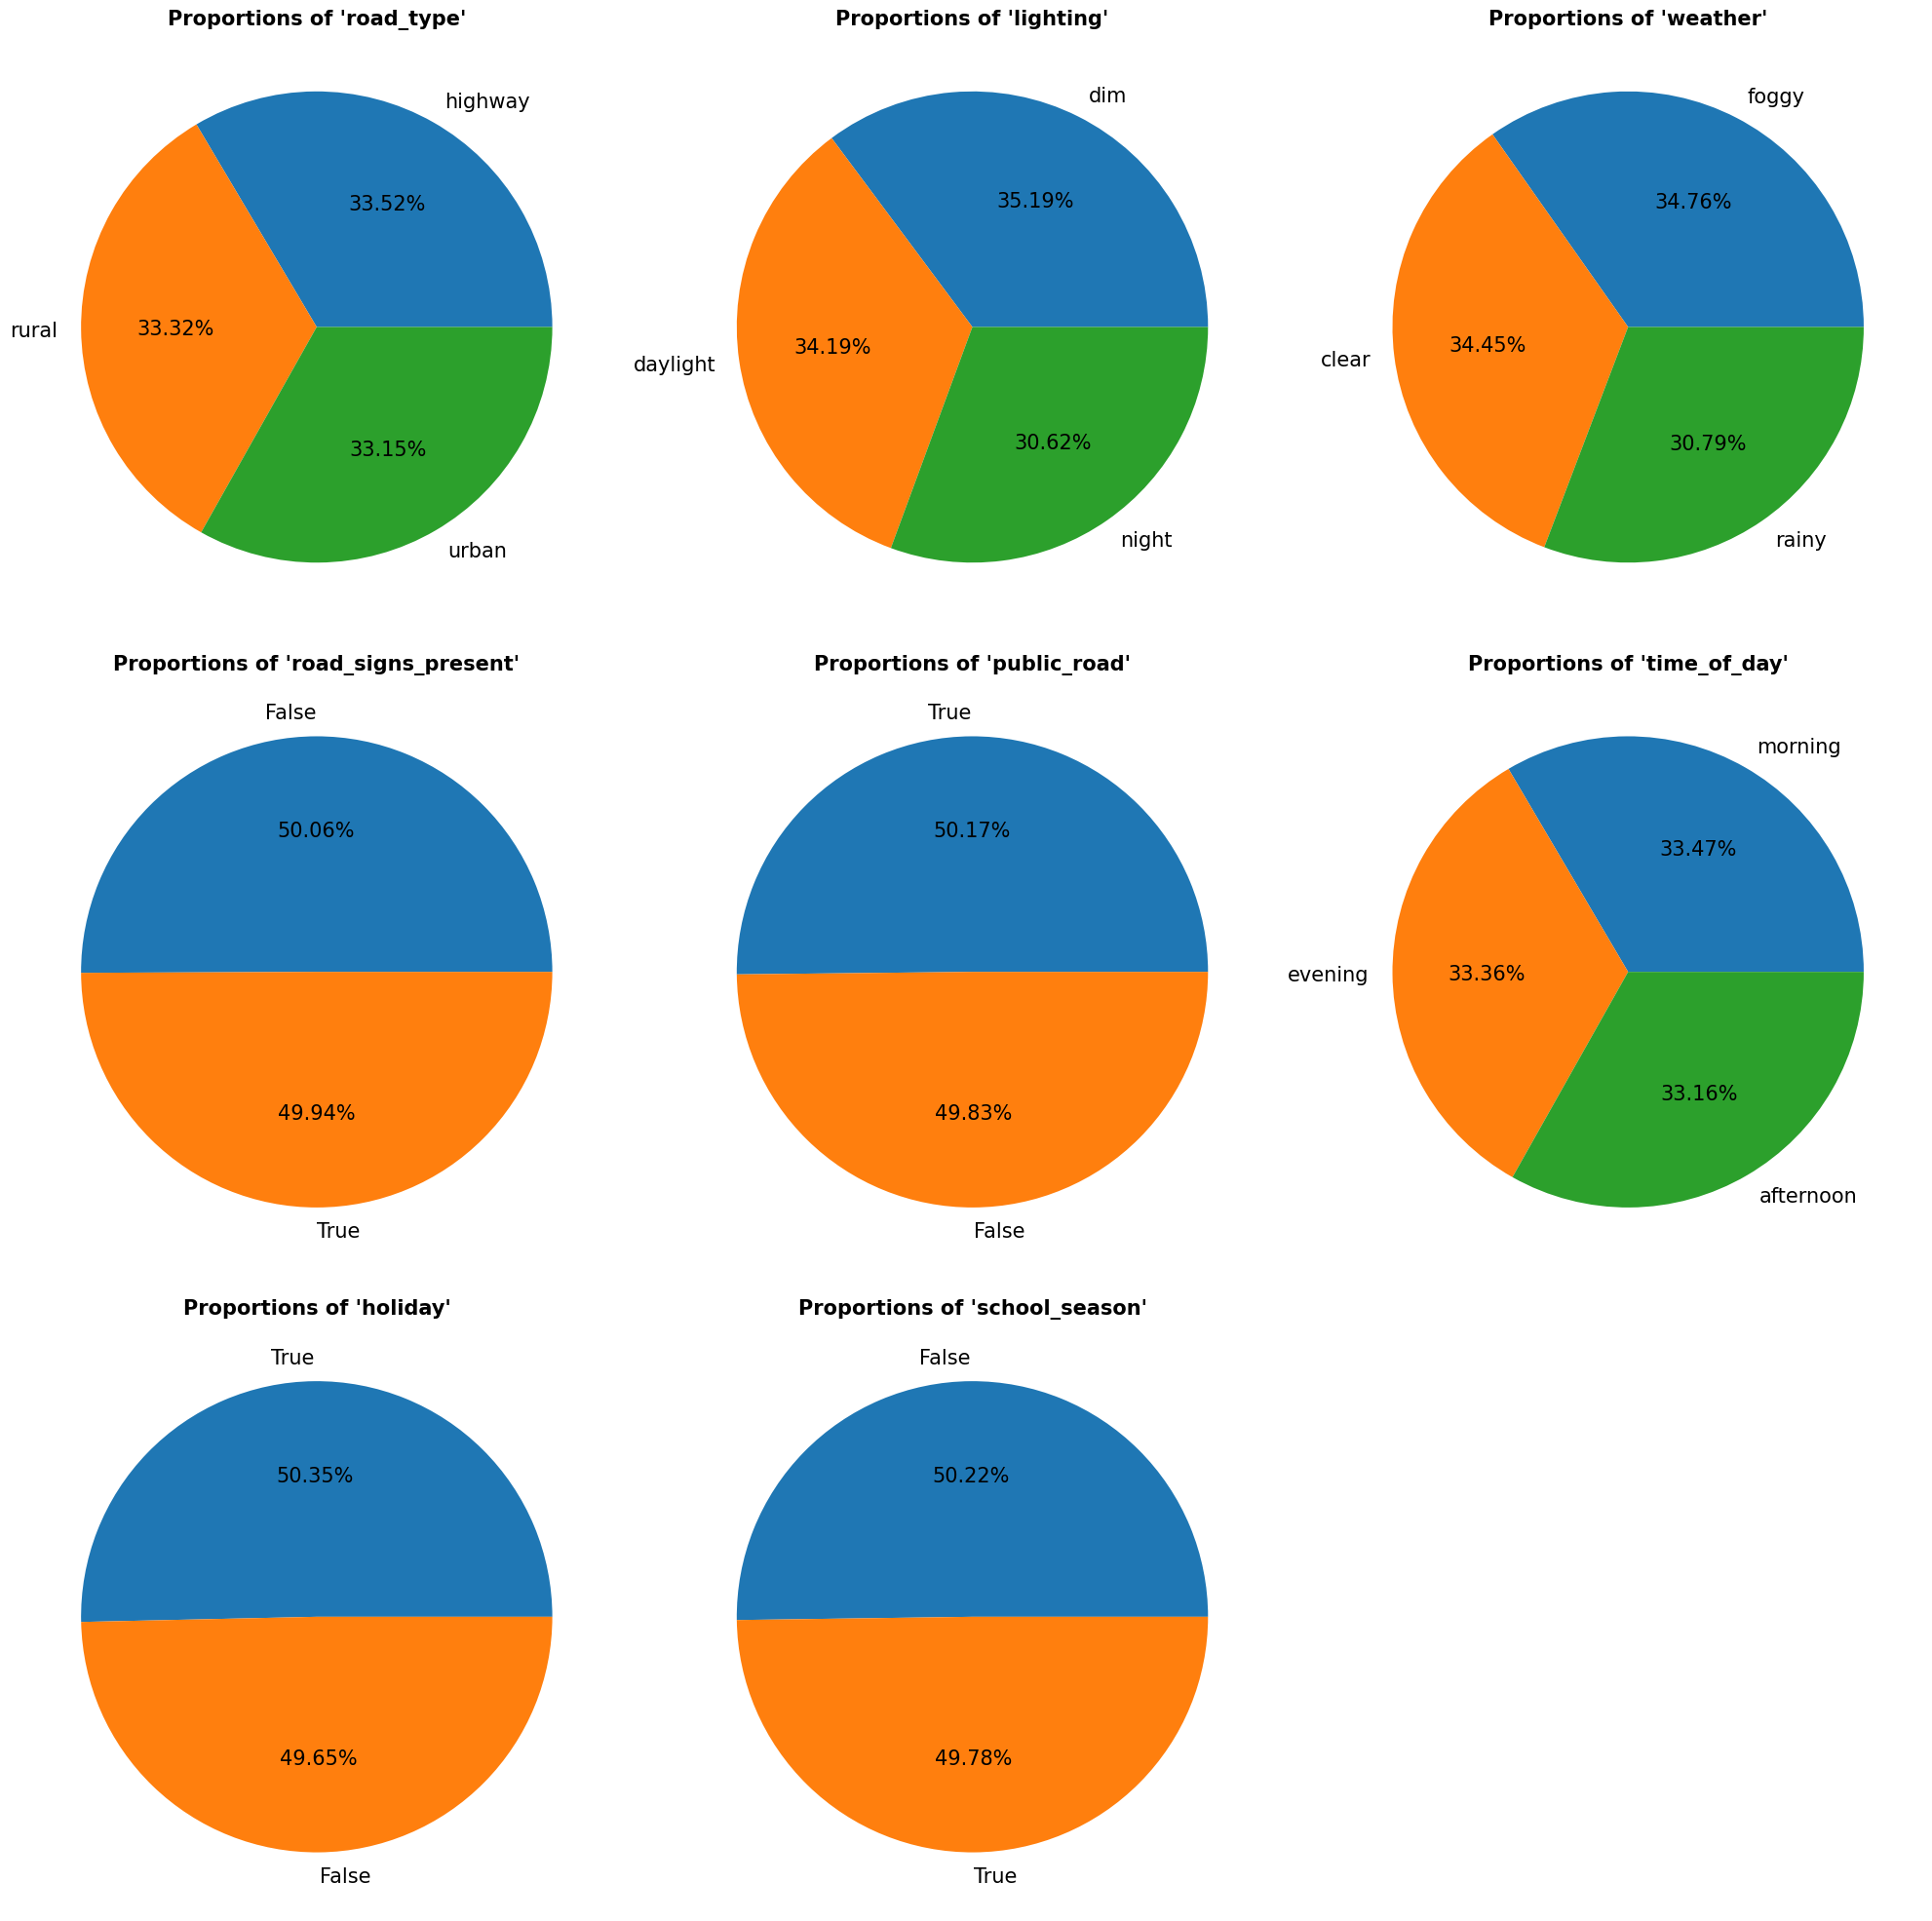

In [16]:
## -- Categorical Features --
plt.figure(figsize=(20, 20))
for i, col in enumerate(CAT_FEATURES):
    plt.subplot(3, 3, i + 1)
    train[col].value_counts(dropna=False).plot(kind='pie', autopct='%1.2f%%', fontsize=15)
    plt.title(f"Proportions of '{col}'", fontsize=15, fontweight='semibold')
    # plt.legend()
    plt.axis('off')

plt.tight_layout()
plt.show()

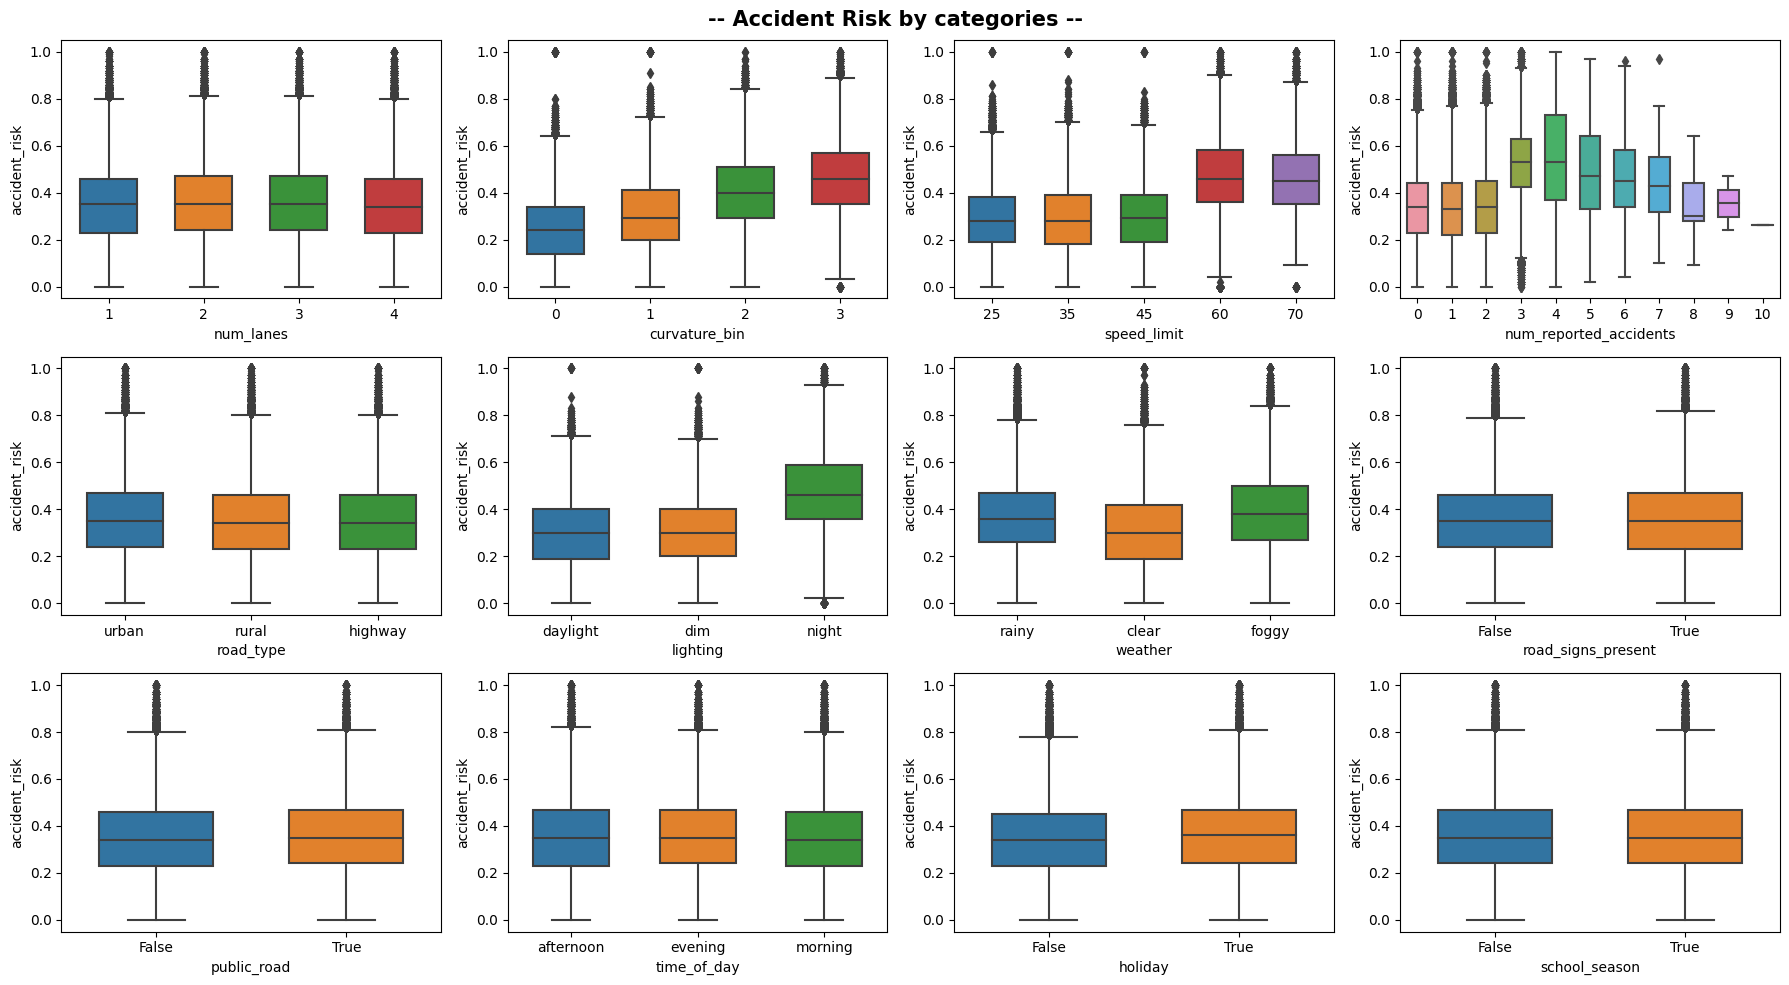

In [17]:
## -- Merge & Binarize float(Curvature) columns --
df = pd.concat([train, test], ignore_index=True)
df['curvature_bin'] = pd.qcut(df['curvature'], q=4, labels=False)

ALL_FEATURES.insert(1, 'curvature_bin')
ALL_FEATURES.remove('curvature')

## -- Target per Category --
plt.figure(figsize=(18, 10))
for i, c in enumerate(ALL_FEATURES):
    plt.subplot(3, 4, i+1)
    sns.boxplot(df.iloc[:len(train)], y=TARGET, x=c, width=0.6)

plt.suptitle('-- Accident Risk by categories --', fontsize=15, fontweight='semibold')
plt.tight_layout()
plt.show()

In [18]:
## -- Label Encode non-numeric --
for c in CAT_FEATURES:
    df[c], _ = pd.factorize(df[c])

train = df.iloc[:len(train)].reset_index(drop=True)
test  = df.iloc[len(train):].drop(TARGET, axis=1).reset_index(drop=True)

train.shape, test.shape

((617754, 14), (172585, 13))

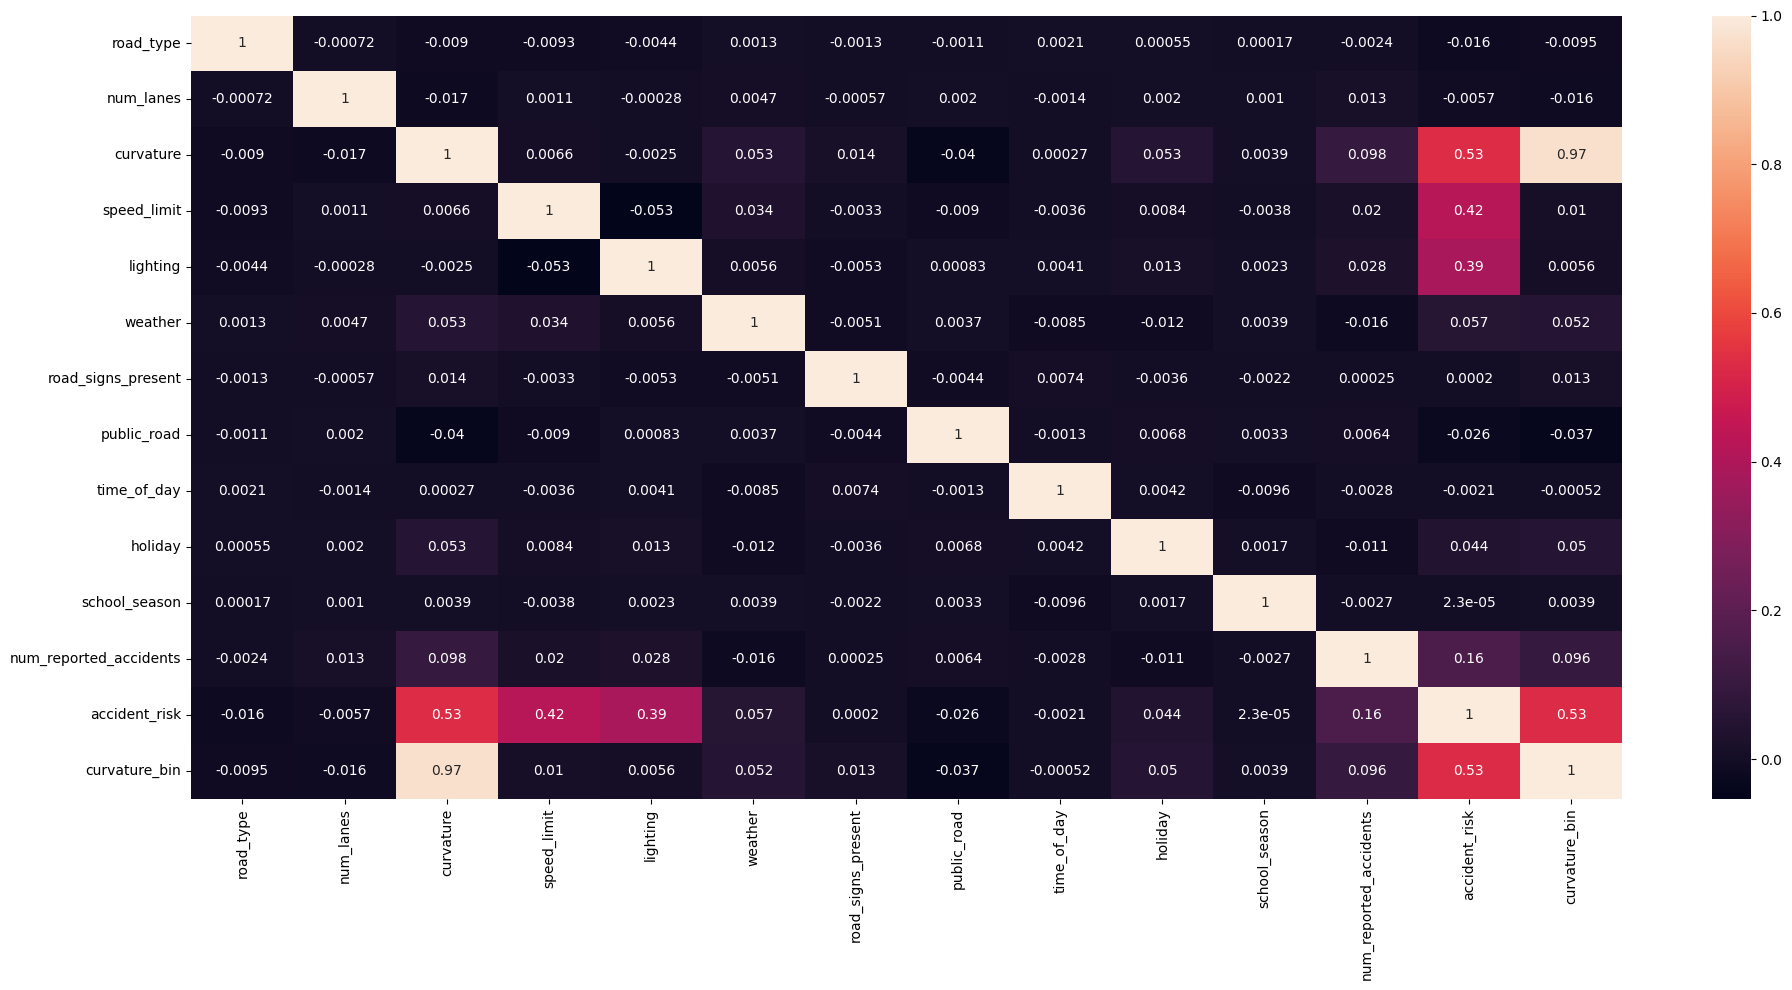

In [19]:
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr(method='spearman'), annot=True)
plt.tight_layout(); plt.show()

In [20]:
display(train.head())
train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,curvature_bin
0,0,2,0.06,35,0,0,0,0,0,0,0,1,0.13,0
1,0,4,0.99,35,0,1,1,1,1,1,0,0,0.35,3
2,1,4,0.63,70,1,1,0,0,2,1,1,2,0.30,2
3,2,4,0.07,35,1,0,1,0,2,0,1,1,0.21,0
4,1,1,0.58,60,0,2,0,1,1,1,1,1,0.56,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617754 entries, 0 to 617753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               617754 non-null  int64  
 1   num_lanes               617754 non-null  int64  
 2   curvature               617754 non-null  float64
 3   speed_limit             617754 non-null  int64  
 4   lighting                617754 non-null  int64  
 5   weather                 617754 non-null  int64  
 6   road_signs_present      617754 non-null  int64  
 7   public_road             617754 non-null  int64  
 8   time_of_day             617754 non-null  int64  
 9   holiday                 617754 non-null  int64  
 10  school_season           617754 non-null  int64  
 11  num_reported_accidents  617754 non-null  int64  
 12  accident_risk           617754 non-null  float64
 13  curvature_bin           617754 non-null  int64  
dtypes: float64(2), int64

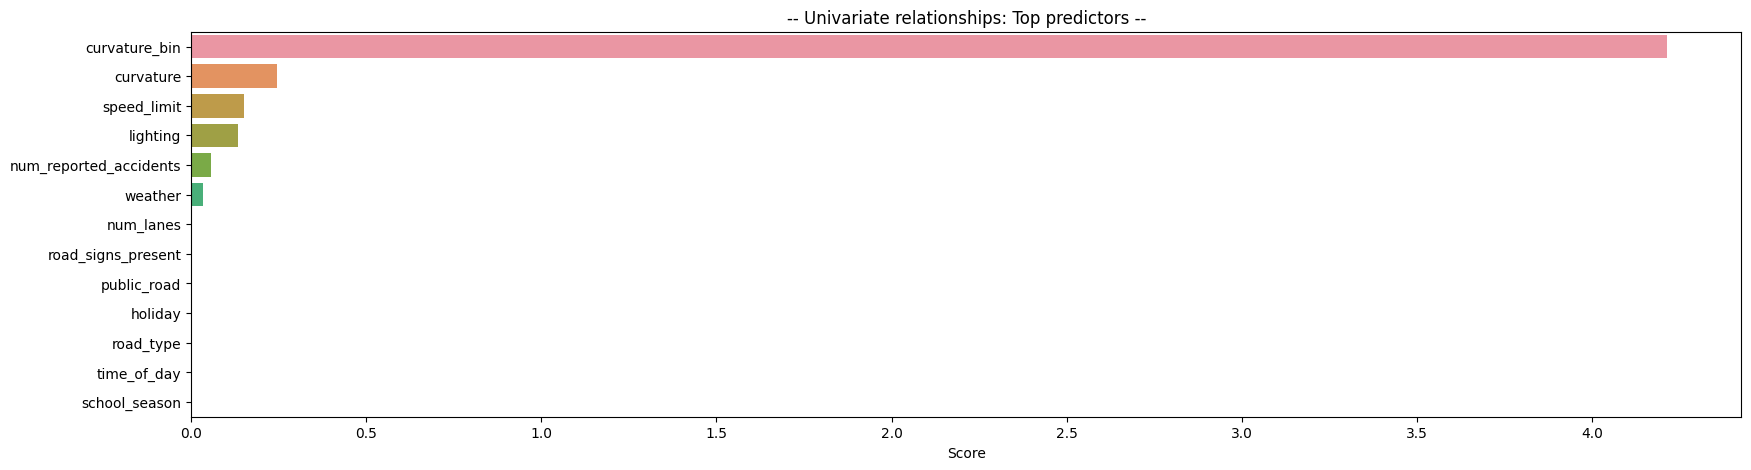

CPU times: user 2min 24s, sys: 421 ms, total: 2min 25s
Wall time: 2min 24s


In [21]:
%%time
## -- Mutual Info: Features vs Target --
mutual_info = mutual_info_regression(train.iloc[:, :-1], train[TARGET], random_state=SEED)
mutual_info_df = pd.DataFrame.from_dict(
    dict(zip(test.columns.tolist(), list(mutual_info))), orient='index', columns=['Score'])\
    .sort_values(by='Score', ascending=False)

plt.figure(figsize=(20, 5))
sns.barplot(data=mutual_info_df, x='Score', y=mutual_info_df.index)
plt.title("-- Univariate relationships: Top predictors --")
plt.show()

### PROFILE REPORT

In [22]:
# %%capture
# ## -- Comprehensive EDA --
# !{sys.executable} -m pip install -U ydata-profiling[notebook]
# !pip install jupyter-contrib-nbextensions
# !jupyter nbextension enable --py widgetsnbextension

# from ydata_profiling import ProfileReport, compare

# ## -- Single EDA --
# profile_df = ProfileReport(train, title="Insights into y Types", explorative=True)
# profile_df.to_notebook_iframe()

# profile_df.to_file("Beats_EDA_Report.html")

# ## -- Create Profiles for Datasets --
# train_report = ProfileReport(train, title="Train", explorative=True)
# test_report = ProfileReport(test, title="Test", explorative=True)
# orig_report = ProfileReport(orig, title="Original", explorative=True)

# ## -- Compare 2++ Datasets --
# comparison_report = compare([train_report, orig_report])

# ## -- Obtain merged statistics (Don't know its purpose yet)
# statistics = comparison_report.get_description()
# ## -- Save report to file
# comparison_report.to_file("Accidents_Train-Orig_Stats.html")
# comparison_report.to_notebook_iframe()

# ML TRAINING

In [23]:
## -- Define Models --
models = {
    'XGB': xgb.XGBRegressor(eval_metric='rmse', n_estimators=100, 
        random_state=SEED, n_jobs=-1, verbosity=0, device=USE_cud,
        ),
    'LGB': lgb.LGBMRegressor(metric='rmse', n_estimators=400, 
        random_state=SEED, n_jobs=-1, verbose=-1, device=USE_gpu,
        ),
    'CAT': cgb.CatBoostRegressor(eval_metric='RMSE', n_estimators=1000, 
        random_state=SEED, task_type=USE_GPU, verbose=0,
        allow_writing_files=False, thread_count=-1,
        ),
}

print(f"Models to train: {len(models)} ---> ", end="")
print(list(models.keys()))

Models to train: 3 ---> ['XGB', 'LGB', 'CAT']


TRAINING MODELS:   0%|          | 0/3 [00:00<?, ?it/s]


[1] XGB ████████████████████████████████████████
	Fold 1 RMSE: 0.056784
	Fold 2 RMSE: 0.056401
	Fold 3 RMSE: 0.055958
	Fold 4 RMSE: 0.056157
	Fold 5 RMSE: 0.056229
	Fold 6 RMSE: 0.055846
	Fold 7 RMSE: 0.055795
	Fold 8 RMSE: 0.056389
	Fold 9 RMSE: 0.055912
	Fold 10 RMSE: 0.055843
|----------------------------------------------------
|  Overall OOF RMSE: 0.056132
| Average Fold RMSE: 0.056131 ± 0.000305


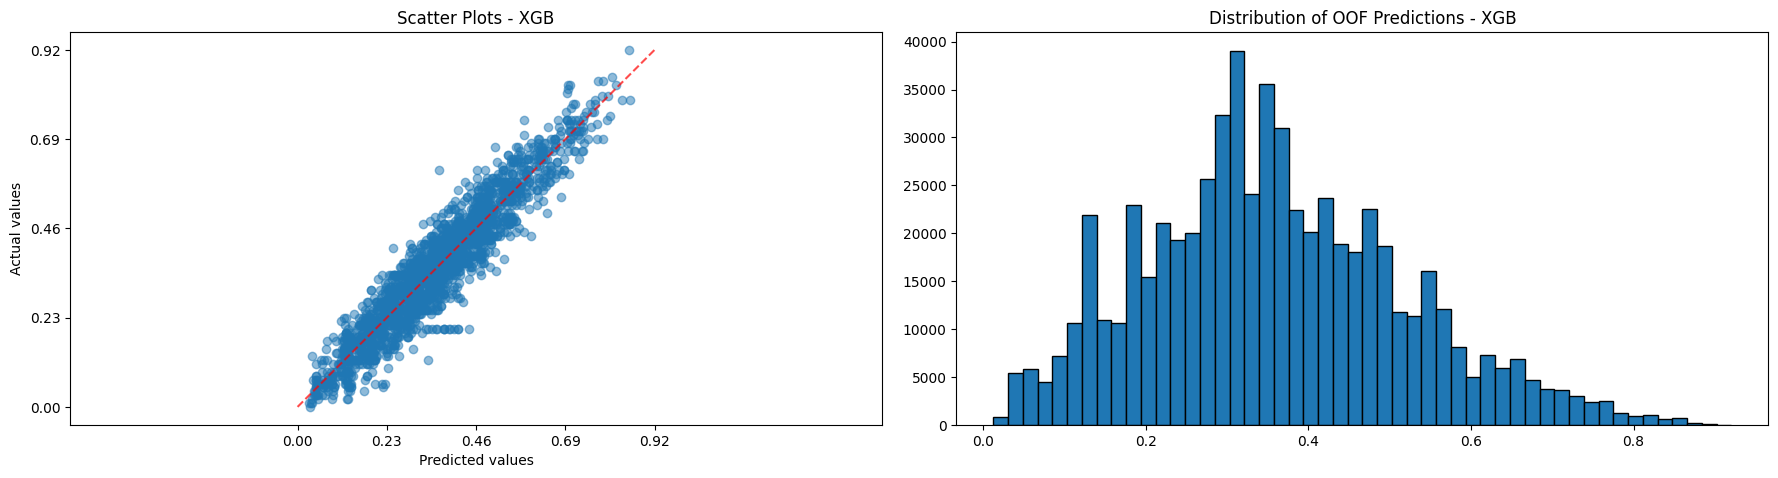

Computation Time: 34.68 secs ################################################################################

[2] LGB ████████████████████████████████████████
	Fold 1 RMSE: 0.056752
	Fold 2 RMSE: 0.056320
	Fold 3 RMSE: 0.055903
	Fold 4 RMSE: 0.056063
	Fold 5 RMSE: 0.056178
	Fold 6 RMSE: 0.055777
	Fold 7 RMSE: 0.055745
	Fold 8 RMSE: 0.056309
	Fold 9 RMSE: 0.055846
	Fold 10 RMSE: 0.055770
|----------------------------------------------------
|  Overall OOF RMSE: 0.056067
| Average Fold RMSE: 0.056066 ± 0.000309


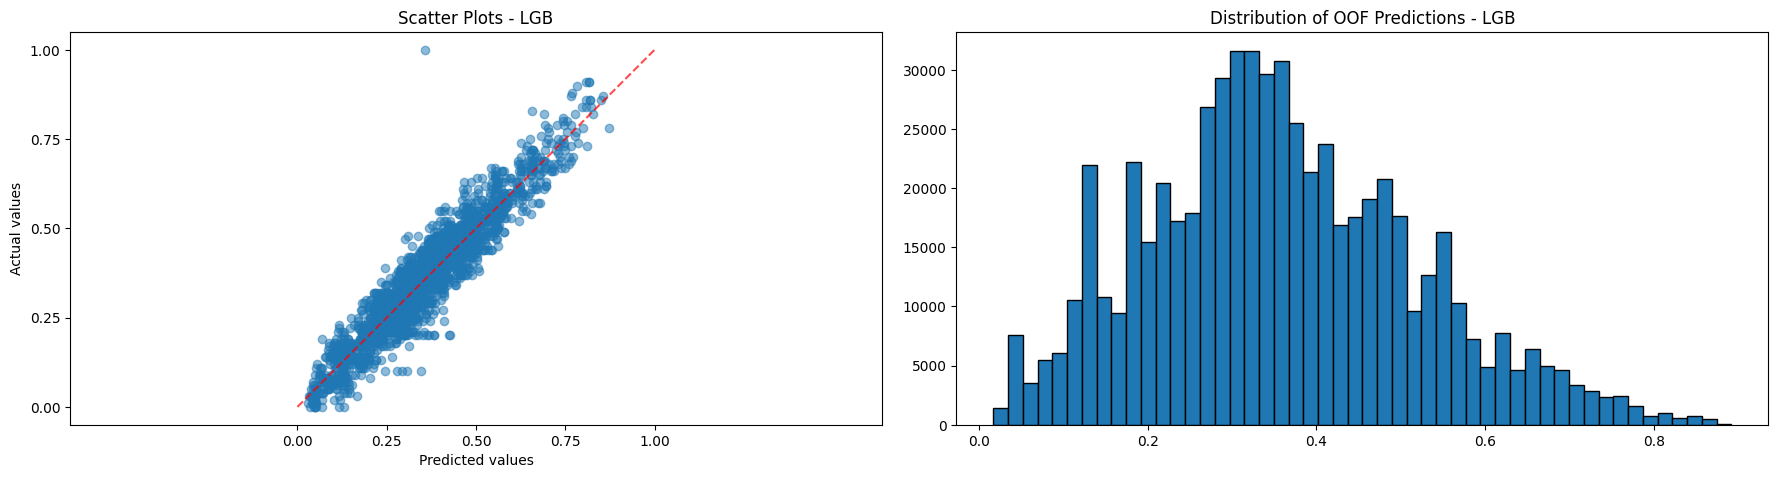

Computation Time: 89.89 secs ################################################################################

[3] CAT ████████████████████████████████████████
	Fold 1 RMSE: 0.056700
	Fold 2 RMSE: 0.056332
	Fold 3 RMSE: 0.055891
	Fold 4 RMSE: 0.056086
	Fold 5 RMSE: 0.056189
	Fold 6 RMSE: 0.055755
	Fold 7 RMSE: 0.055729
	Fold 8 RMSE: 0.056274
	Fold 9 RMSE: 0.055824
	Fold 10 RMSE: 0.055741
|----------------------------------------------------
|  Overall OOF RMSE: 0.056053
| Average Fold RMSE: 0.056052 ± 0.000306


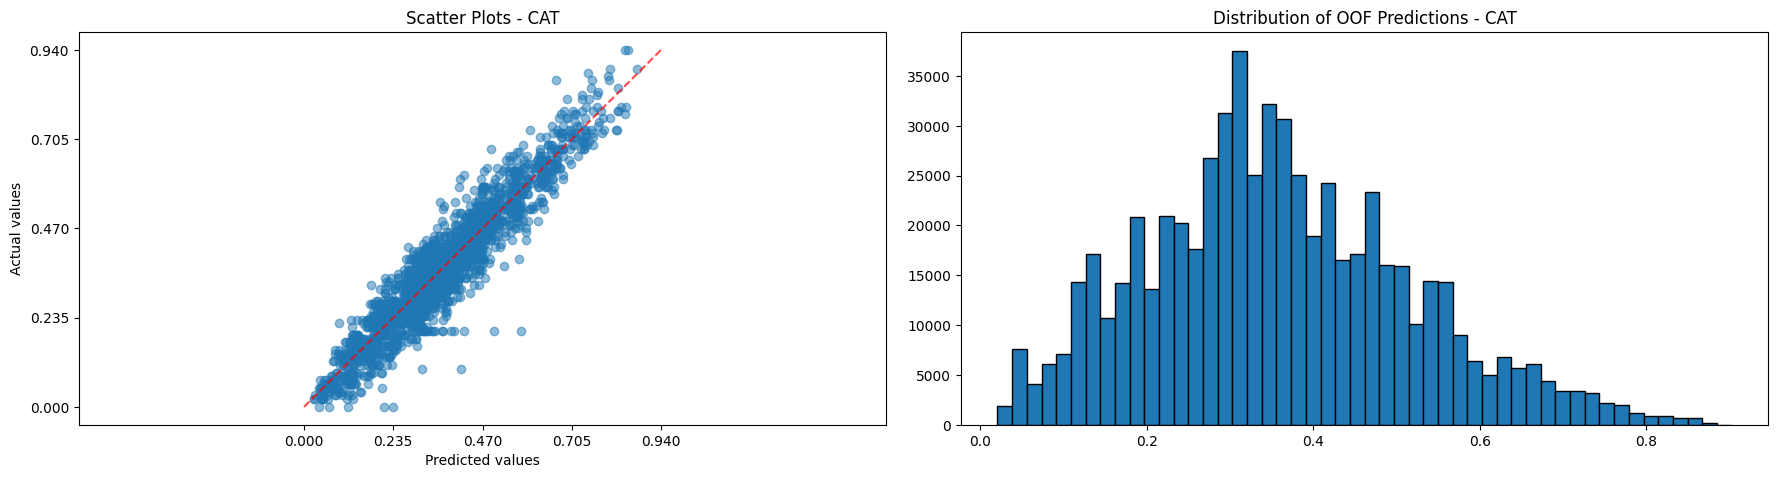

Computation Time: 391.65 secs ################################################################################


In [24]:
## -- DEFINE TRAINING PARAMETERS -- ##
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
## -- Split data --
X = train.drop(TARGET, axis=1)
y = train[TARGET]

oof_final_df = pd.DataFrame()
test_final_df = pd.DataFrame()

MODELS_FIT = {}
FOLDS      = 10
REPEATS    = 2

# kf = RepeatedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

## -- Initiate Training -- ##
## -----------------------------------------------------------------------
for i, (name, model) in tqdm(enumerate(models.items(), 1), total=len(models), desc="TRAINING MODELS"):
    print(f"\n[{i}] {COLOR}{name} {'█'*40}{RESET}")
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_RMSEs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
        model.fit(X_train_fold, y_train_fold)
        y_fold_pred = model.predict(X_val_fold)
        oof_preds[val_idx] = np.clip(y_fold_pred, 0, 1)

        # Predict on test set (accumulate final prediction)
        predictions = model.predict(test)
        test_preds += np.clip(predictions, 0, 1) / FOLDS #* REPEATS

        # Compute RMSE for validation fold
        fold_rmse = rmse(y_val_fold, y_fold_pred)
        fold_RMSEs.append(fold_rmse)

        print(f"\tFold {fold} RMSE: {fold_rmse:.6f}")

    ## -- After all folds:
    overall_RMSE = rmse(y, oof_preds)
    print(f"|{'-'*52}")
    print(f"{COLOR}|  Overall OOF RMSE: {overall_RMSE:.6f}")
    print(f"| Average Fold RMSE: {np.mean(fold_RMSEs):.6f} ± {np.std(fold_RMSEs):.6f}{RESET}")
    ## -- Plot ROC CURVE --
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))
    display = PredictionErrorDisplay.from_predictions(
                        y, oof_preds, ax=axs[0],
                        kind="actual_vs_predicted",
                        subsample=2000,
                        scatter_kwargs={"alpha": 0.5},
                        line_kwargs={'color': 'r'},
                    )
    axs[0].set_title(f"Scatter Plots - {name}")
    # -----------------------------------------------------
    axs[1].hist(oof_preds, bins=50, ec='k')
    axs[1].set_title(f"Distribution of OOF Predictions - {name}") 
    # -----------------------------------------------------
    for ax in axs: ax.grid(False)
    fig.tight_layout(pad=1.5) 
    plt.show()

    oof_final_df[name]  = oof_preds
    test_final_df[name] = test_preds
    MODELS_FIT[name]    = model

    tok = time()
    tiktok = tok-tik
    print(f"Computation Time: {tiktok:.2f} secs {'#'*80}")

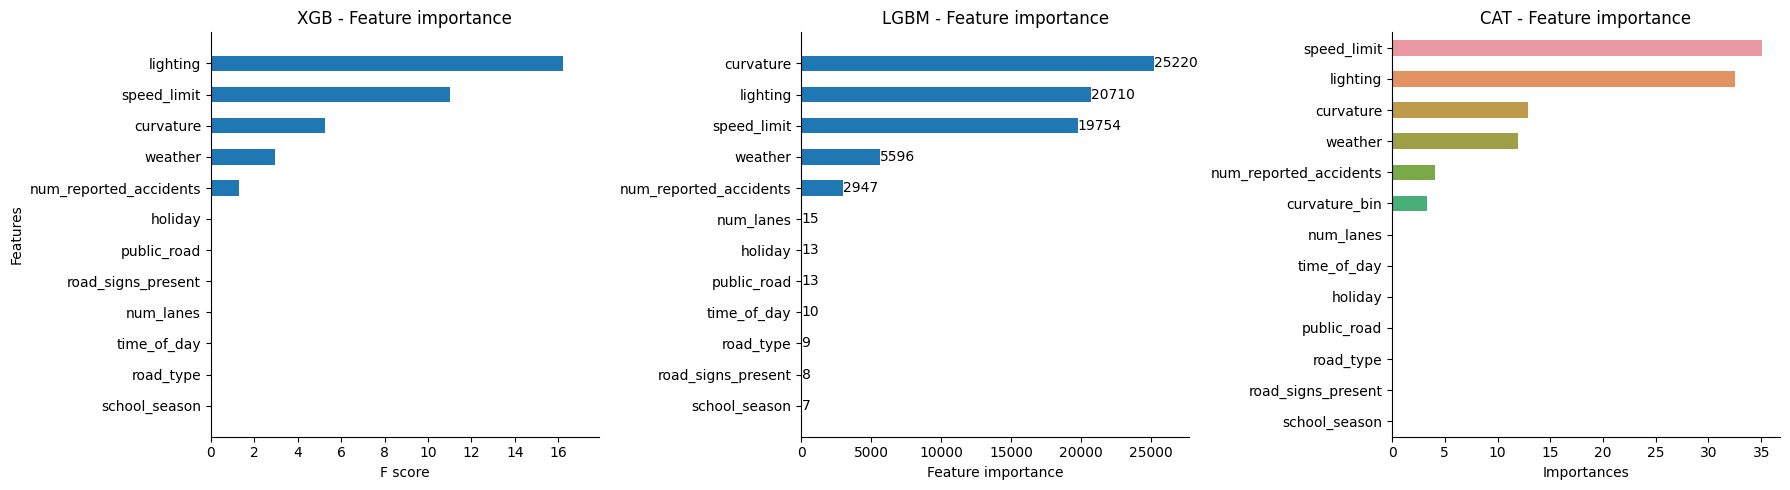

In [25]:
## -- PLOT FEATURES IMPORTANCES -- 
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

## -- XGBoost -- 
xgb.plot_importance(MODELS_FIT['XGB'], importance_type='gain',
                    ax=axs[0], grid=False, height=.5, show_values=False,
                    title="XGB - Feature importance")

## -- LightGBM -- 
lgb.plot_importance(MODELS_FIT['LGB'], importance_type='gain',
                    ax=axs[1], grid=False, height=.5, precision=0,
                    title="LGBM - Feature importance")
axs[1].set_ylabel("")

## -- CatBoost -- 
cat_imp_df = MODELS_FIT['CAT'].get_feature_importance(prettified=True)
sns.barplot(data=cat_imp_df, x='Importances', y='Feature Id', width=.5, ax=axs[2])
axs[2].set_title('CAT - Feature importance')
axs[2].set_ylabel("")

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

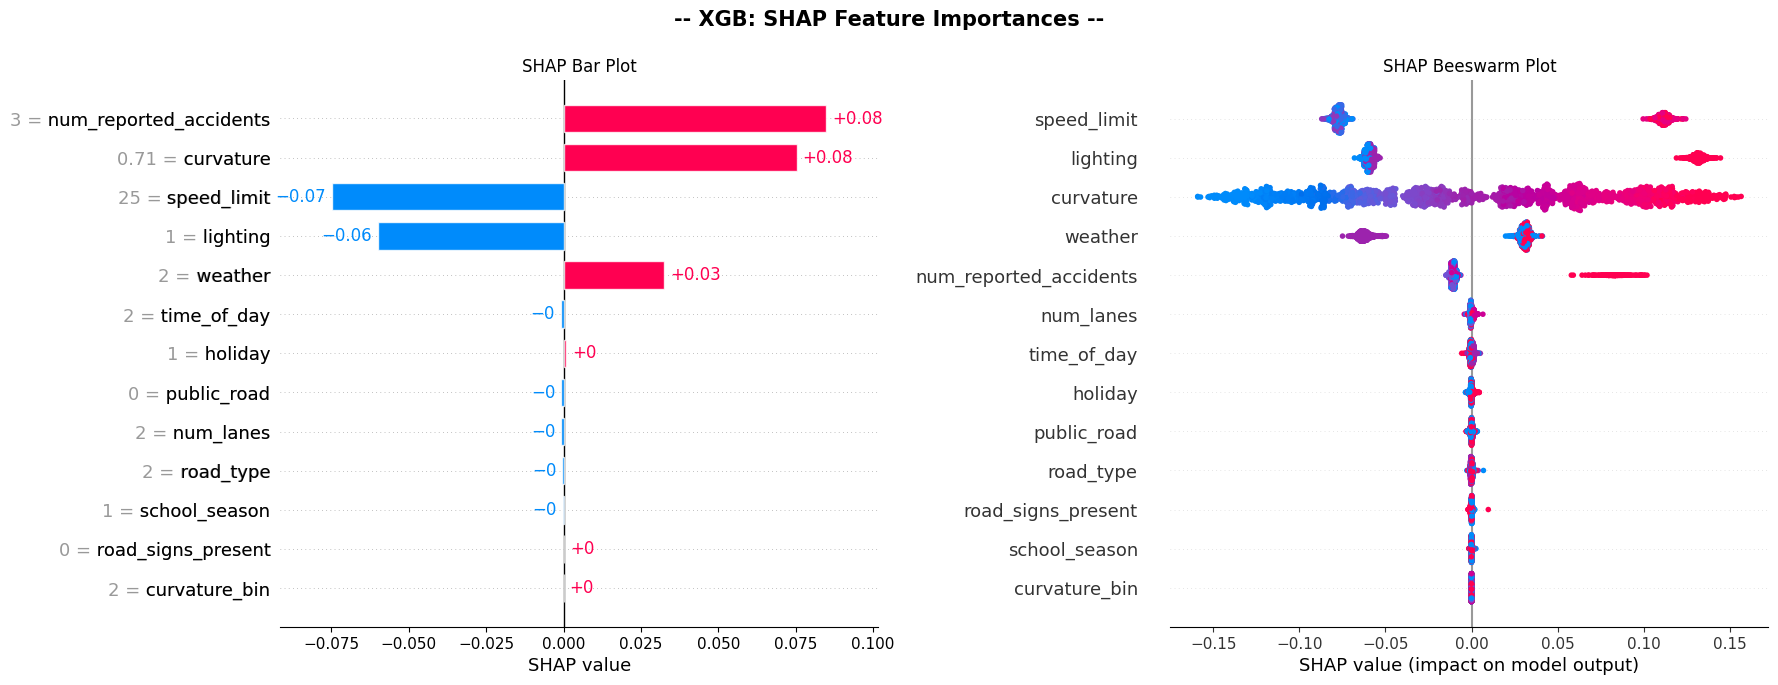

 96%|=================== | 1910/2000 [00:18<00:00]       

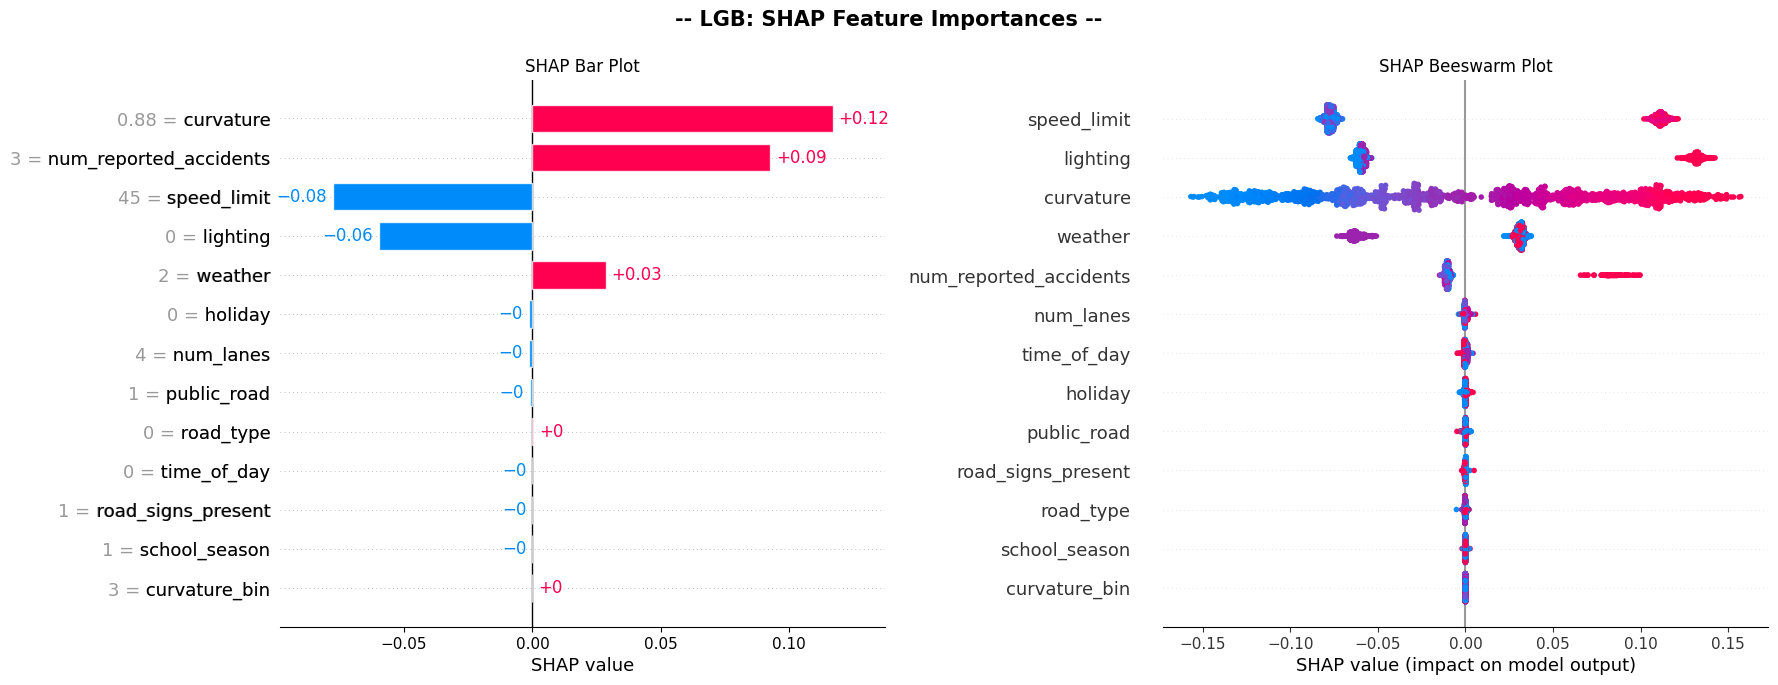

100%|===================| 1991/2000 [02:08<00:00]       

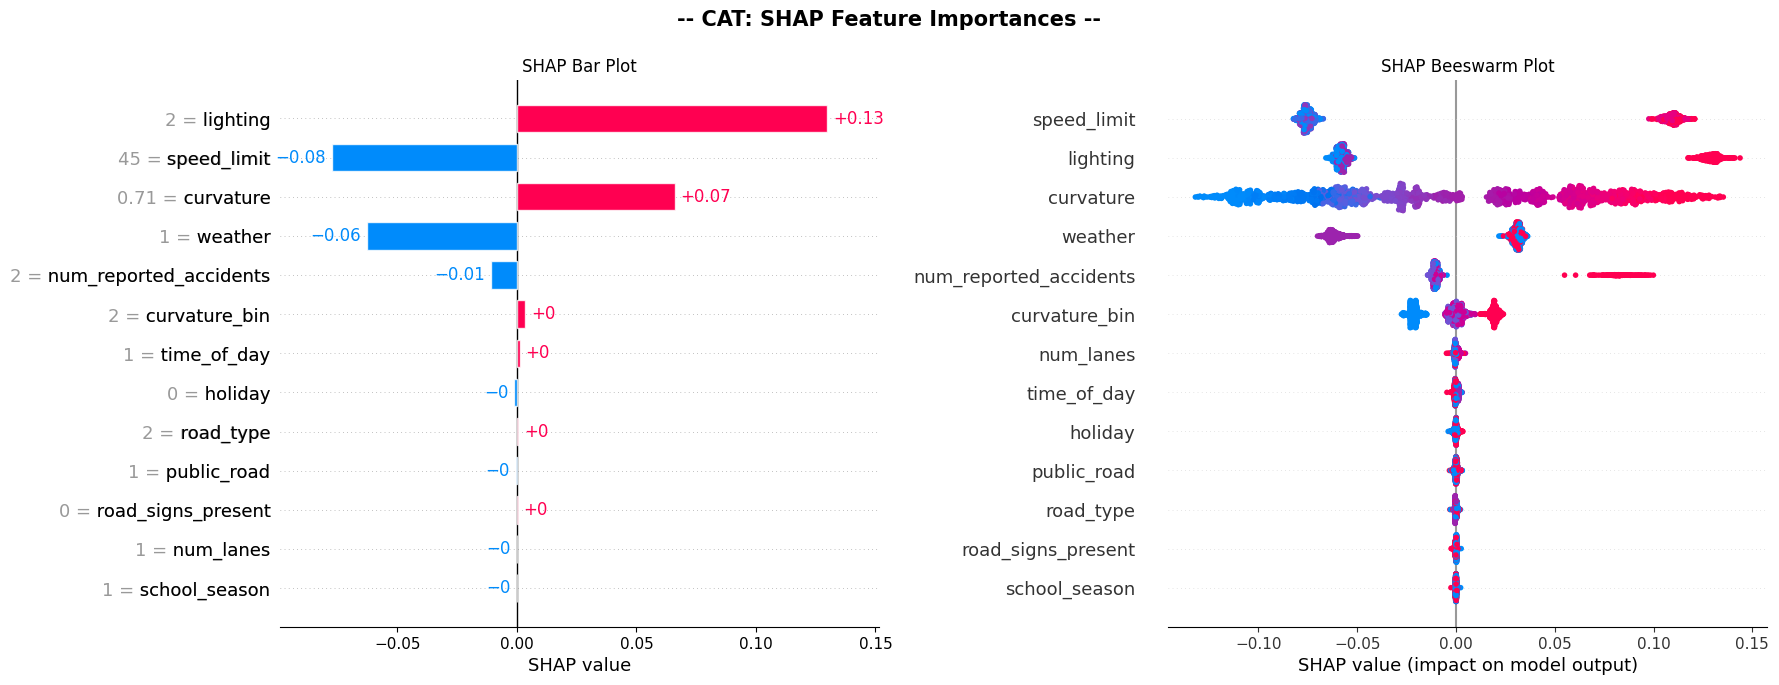

In [26]:
## -- Plot SHAP values --
MAX = 20
for i, (name, model) in enumerate(MODELS_FIT.items()):
    fig, axs = plt.subplots(1, 2, figsize=(18, 7))
    # Create Explainer/Shap Values
    explainer = shap.TreeExplainer(model, X_val_fold)
    shap_values = explainer(X_val_fold.sample(2000))
    # Bar plot on first subplot
    shap.plots.bar(shap_values[0], show=False, max_display=MAX, ax=axs[0])
    axs[0].set_title("SHAP Bar Plot")
    # Beeswarm plot on second subplot
    shap.plots.beeswarm(shap_values, show=False, max_display=MAX, ax=axs[1],
                        color_bar=False, plot_size=None)
    axs[1].set_title("SHAP Beeswarm Plot") 
    # Add suptitle and adjust layout
    fig.suptitle(f"-- {name}: SHAP Feature Importances --", fontsize=15, fontweight='semibold')
    fig.tight_layout(pad=1.5) 
    plt.show()
    print()

In [27]:
## -- Predictions/OOF of models --
test_final_df.head(), oof_final_df.head()

(        XGB       LGB       CAT
 0  0.289844  0.291172  0.294105
 1  0.118264  0.122723  0.118272
 2  0.184904  0.186235  0.188235
 3  0.340524  0.344869  0.343462
 4  0.382395  0.388743  0.380716,
         XGB       LGB       CAT
 0  0.133290  0.127827  0.127153
 1  0.318934  0.319626  0.319428
 2  0.389198  0.386680  0.386328
 3  0.123233  0.130147  0.124035
 4  0.478050  0.475231  0.473874)

In [28]:
## -- Create Submissions for all models --
for c in test_final_df.columns:
    submit[TARGET] = test_final_df[c].values
    submit.to_csv(f"submit_{c}_base.csv", index=False)
    print(f"{COLOR}-> submit_{c}_base.csv saved!")

-> submit_XGB_base.csv saved!
-> submit_LGB_base.csv saved!
-> submit_CAT_base.csv saved!
